In [2]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import eikon as ek
ek.set_app_key("15fd3a43a9c74e33958b04533bfae5607781a37a")


Using TensorFlow backend.


In [3]:
%load_ext tensorboard
import datetime, os


In [4]:
#Importing year ahead continuation prices for carbon, coal, gas and oil (brent front month) using rics from Eikon and storing in seperate dataframes
#before merging dataframes to one

rics = ["CFI2Zc1", "ATWYc1", "TRNLTTFYc1", "LCOc1"]
columns = ["EUA", "API2", "TTF", "Brent"] 

df_EUA = ek.get_timeseries(rics[0],
                       start_date = "2010-01-01",
                       fields = "CLOSE"
                       )
df_API2 = ek.get_timeseries(rics[1],
                       start_date = "2010-01-01",
                       fields = "CLOSE"
                       )
df_TTF = ek.get_timeseries(rics[2],
                       start_date = "2010-01-01",
                       fields = "CLOSE"
                       )
df_Brent = ek.get_timeseries(rics[3],
                       start_date = "2010-01-01",
                       fields = "CLOSE"
                       )
df_list = [df_EUA, df_API2, df_TTF, df_Brent]

df = df_list[0]
for df_ in df_list[1:]:
    df = df.merge(df_, left_index=True, right_index=True)

df.columns = columns
df.dropna()
df.index = pd.DatetimeIndex(data=df.index)
df.head()

C:\Users\u6041727\miniconda3\envs\tensorflow\lib\site-packages\eikon\time_series.py:282: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.array(timeseries['dataPoints'])
C:\Users\u6041727\miniconda3\envs\tensorflow\lib\site-packages\eikon\time_series.py:284: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  timestamps = pd.np.array([tz_replacer(value) for value in datapoints[:, timestamp_index]],
C:\Users\u6041727\miniconda3\envs\tensorflow\lib\site-packages\eikon\time_series.py:286: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.delete(datapoints, pd.np.s_[timestamp_index],
C:\Users\u6041727\miniconda3\envs\tensorflow\lib\site-packages\eikon\time_series.py:209: FutureWarning: The pandas.np mod

,EUA,API2,TTF,Brent
Date,,,,
2010-01-04,13.09,90.53,18.91,80.12
2010-01-05,12.70,94.14,18.88,80.59
2010-01-06,12.41,94.68,18.64,81.89
2010-01-07,12.73,97.73,18.72,81.51
2010-01-08,13.00,95.85,18.26,81.37


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2569 entries, 2010-01-04 to 2020-02-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUA     2569 non-null   float64
 1   API2    2569 non-null   float64
 2   TTF     2568 non-null   float64
 3   Brent   2569 non-null   float64
dtypes: float64(4)
memory usage: 100.4 KB


In [6]:
#Create new column with target price for EUA which is next day's close
df["Target"] = df["EUA"].shift(1)
df = df.dropna()
df.head()

,EUA,API2,TTF,Brent,Target
Date,,,,,
2010-01-05,12.70,94.14,18.88,80.59,13.09
2010-01-06,12.41,94.68,18.64,81.89,12.70
2010-01-07,12.73,97.73,18.72,81.51,12.41
2010-01-08,13.00,95.85,18.26,81.37,12.73
2010-01-11,13.18,93.50,18.06,80.97,13.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2567 entries, 2010-01-05 to 2020-02-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUA     2567 non-null   float64
 1   API2    2567 non-null   float64
 2   TTF     2567 non-null   float64
 3   Brent   2567 non-null   float64
 4   Target  2567 non-null   float64
dtypes: float64(5)
memory usage: 120.3 KB


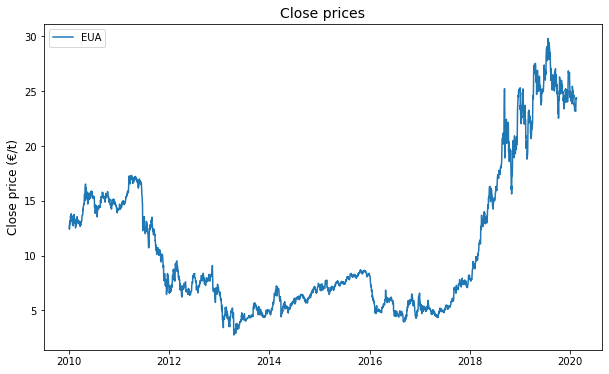

In [8]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,6))
plt.title("Close prices", fontsize=14)
plt.plot(df["EUA"])
#plt.xlabel("Date", fontsize=18)
plt.ylabel("Close price (€/t)", fontsize=12)
plt.legend(columns)
plt.show()

In [9]:
#Filter out Target from df to create training dataset
training_df = df.filter(columns)
#Create numpy array 
data_np = df.values
print(data_np.shape)
data_np[-1,0]

(2567, 5)


24.33

In [10]:
#Create training and test data based only on EUA historic price
train_size = math.ceil(len(data_np)*0.8)
train = data_np[0:train_size,0]
test = data_np[train_size - 60:,0]

#Reshape data to 2D array
train = train.reshape(-1,1)
test = test.reshape(-1,1)
print(test.shape)
print('Observations: %d' % (len(data_np)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


(573, 1)
Observations: 2567
Training Observations: 2054
Testing Observations: 573


In [11]:
#Calculating mean and variance for the EUA price for training and test dataset and we can see that the mean and variance are
#different with a large margin between the two datasets -> not stationary data

from numpy import mean
from numpy import var
mean_train = mean(train) #The average of the EUA price
var_train = var(train) #Variance meassure how much values in the distribution varies with respect to the mean
mean_test = mean(test)
var_test = var(test)
print("The mean of the training data is: ", mean_train)
print("The variance of the training data is: ", var_train)
print("")
print("The mean of the test data is: ", mean_test)
print("The variance of the test data is: ", var_test)

The mean of the training data is:  8.08537487828627
The variance of the training data is:  13.697466826360138

The mean of the test data is:  19.87282722513089
The variance of the test data is:  39.450442268578165


In [12]:
#Scale and normalize the data
#Scale (normalize) the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_data = scaler.fit_transform(train)
scaled_test_data = scaler.fit_transform(test)
print(scaled_training_data.shape)
print(scaled_test_data.shape)

(2054, 1)
(573, 1)


In [13]:
#Split the data into x_train and y_train data sets.
x_train = []
y_train = []

for i in range(60, len(scaled_training_data)):
  x_train.append(scaled_training_data[i-60:i,0])
  y_train.append(scaled_training_data[i,0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

[array([0.68337912, 0.66346154, 0.68543956, 0.70398352, 0.71634615,
       0.69505495, 0.71016484, 0.74519231, 0.72733516, 0.75274725,
       0.75961538, 0.7293956 , 0.72115385, 0.71291209, 0.73489011,
       0.74587912, 0.73145604, 0.7135989 , 0.69436813, 0.68475275,
       0.68612637, 0.68681319, 0.71909341, 0.72252747, 0.75549451,
       0.74175824, 0.72184066, 0.71703297, 0.70054945, 0.71291209,
       0.72527473, 0.6978022 , 0.70123626, 0.67101648, 0.68887363,
       0.68543956, 0.7081044 , 0.69711538, 0.70398352, 0.72664835,
       0.72458791, 0.74107143, 0.71222527, 0.72458791, 0.71085165,
       0.71291209, 0.71978022, 0.7032967 , 0.69711538, 0.71016484,
       0.70260989, 0.70673077, 0.71153846, 0.71222527, 0.7135989 ,
       0.69848901, 0.68887363, 0.68063187, 0.69848901, 0.68818681])]
[0.6929945054945056]

[array([0.68337912, 0.66346154, 0.68543956, 0.70398352, 0.71634615,
       0.69505495, 0.71016484, 0.74519231, 0.72733516, 0.75274725,
       0.75961538, 0.7293956 , 0.721

In [14]:
#Split the data into x_test and y_test data sets.
x_test = []
y_test = []

for i in range(60, len(scaled_test_data)):
    x_test.append(scaled_test_data[i-60:i,0])
    y_test.append(scaled_test_data[i,0])
    #if i<=61:
        #print(x_test)

#Convert x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)

(1994, 60)
(1994,)


In [15]:
#Reshape the data as LSTM requires three dimensional shape
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
Y_train = y_train
Y_test = y_test

print(X_train.shape)
print(X_test.shape)

(1994, 60, 1)
(513, 60, 1)


In [18]:
#Build the LSTM model

# tf.keras.models.Sequential([tf.keras.layers.LSTM(10, return_sequences = True, input_shape=(x_train.shape[1],1)),
# tf.keras.layers.LSTM(10, return_sequences = False),
# tf.keras.layers.Dense(5),
# tf.keras.layers.Dense(1)
# ])

model=Sequential()
model.add(LSTM(10, return_sequences = True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(10, return_sequences = False))
model.add(Dense(10))
model.add(Dense(1))
          

In [19]:
#Compile the model using Adam optimizer and mean squared error to meassure loss
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [20]:
# import time
# NAME = "EUA_price_Eikon{}".format(int(time.time()))
# #logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(log_dir="logs\{}".format(NAME))

In [21]:
#Train the model
model.fit(X_train, 
          Y_train,
          batch_size=1,
          epochs=1,
          validation_data=(X_test, Y_test),
          shuffle=True
          )

Train on 1994 samples, validate on 513 samples
Epoch 1/1
1994/1994 [==============================] - 129s 65ms/step - loss: 0.0028 - val_loss: 0.0024


In [26]:
#Get the model's predicted price values in test dataset
predictions= model.predict(X_test)
obj = scaler.fit(test)
predictions = obj.inverse_transform(predictions)
prediction = predictions[len(predictions)-1]

#Transform y_test form normalized to normal numbers
y_test_rescaled = scaler.inverse_transform(Y_test.reshape(-1,1))

#Get the RMSE to meassure how accurate the model is (low RMSE- good performance!)
rmse= np.sqrt( np.square(np.subtract(y_test_rescaled[:,0],predictions[:,0])).mean())
mse = np.square(np.subtract(y_test_rescaled[:,0],predictions[:,0])).mean()

print("Root mean squared error:", round(rmse,2))
print("Mean squared error:", round(mse,2))
print("Model predicted yesterday's EUA price at:", round(float(predictions[-2]),2), "yesterday")
print("Yesterday's price was:", float(y_test_rescaled[-1]))


Root mean squared error: 0.93
Mean squared error: 0.87
Model predicted yesterday's EUA price at: 23.5 yesterday
Yesterday's price was: 24.29


In [27]:
#Predict day-ahead price
prediction_df = data_np[train_size-60:,0]
#Get the last 60 days closing prices and conver to array
last_60_days = prediction_df[-60:]

#Scale the data
scaler = MinMaxScaler(feature_range = (0,1))
last_60_days_scaled = scaler.fit_transform(last_60_days.reshape(-1,1))
#Create an empty list
X_predictions = []
X_predictions.append(last_60_days_scaled)
#Convert to numpy array
X_predictions = np.array(X_predictions)
#Reshape the data
X_predictions = np.reshape(X_predictions, (X_predictions.shape[0], X_predictions.shape[1], 1))
#Get predicted scaled prediction
pred_price = model.predict(X_predictions)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
pred_price = float(pred_price)
print("The model predicts today's price at:", round(pred_price,2), "based on last 60 days prices")


The model predicts today's price at: 23.81 based on last 60 days prices


<function matplotlib.pyplot.show(*args, **kw)>

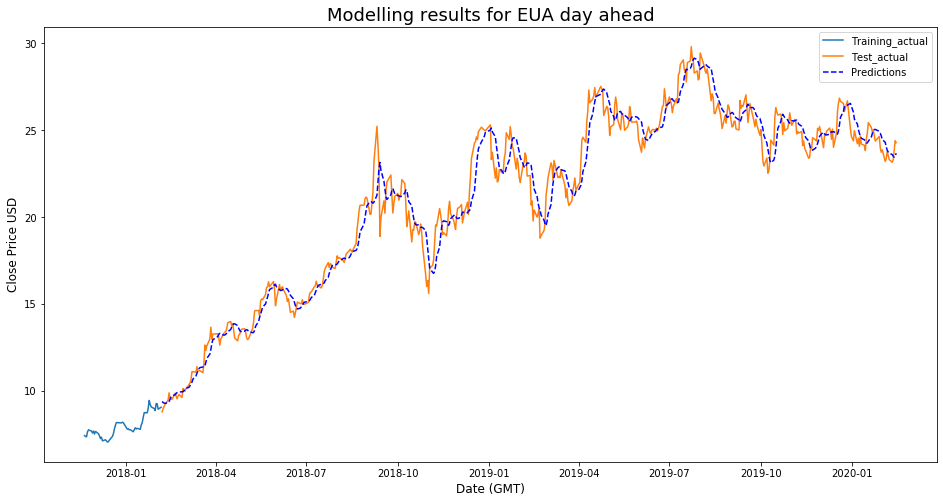

In [28]:
# #Plot the data
training = df["EUA"].iloc[2000:train_size]
testing = df["EUA"].iloc[train_size:]
df_predictions = pd.DataFrame(predictions)
df_predictions.index = pd.DatetimeIndex(data=testing.index)
        
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Modelling results for EUA day ahead", fontsize = 18)
plt.xlabel("Date (GMT)", fontsize=12)
plt.ylabel("Close Price USD", fontsize=12)
plt.plot(training, label = "Training_actual")
plt.plot(testing, label = "Test_actual")
plt.plot(df_predictions, "--b",label = "Predictions")

plt.legend()
plt.show

In [29]:
#Define a classifier function which will classify if day-ahead price will go up, down or stay neutral
from statistics import stdev

def classify(last_day, neutral_range, pred_price):
  if 0.43 * neutral_range > (pct_change.iloc[-1] - pct_change.iloc[-2]) > -0.43 * neutral_range:
    return "Neutral"
  elif float(pred_price) > float(last_day):
    return "Bullish"
  else:
    return "Bearish" 

#Define last day and second last day
last_day = float(y_test_rescaled[-1])
second_last_day = float(y_test_rescaled[-2])

#Neutral range = 0.43*σ > ∆p > -0.43*σ
#∆p is  the price movement (in %) from one day to another and σ is the 
#standard deviation of daily price movements (in %) over the previous 3 months (assume 60 trading days).
#Create dataframe with percentage change
pct_change = df["EUA"].pct_change()
pct_change = pct_change.dropna()
stdev_last_60_days = stdev(pct_change[len(pct_change)-60:])
neutral_range = stdev_last_60_days


print("Neutral range is:", round(neutral_range, 2))
print("Yesterday's closing price was: ", last_day)
print("Today's predicted price is: ", round(pred_price, 2))
print("Difference between pred_price and last_day:",round((pred_price - last_day), 2))
print("Daily view: ", classify(last_day,neutral_range, pred_price))


Neutral range is: 0.02
Yesterday's closing price was:  24.29
Today's predicted price is:  23.81
Difference between pred_price and last_day: -0.48
Daily view:  Bearish


In [30]:
#Performance test of the model. Based on historic price in test dataset, classify if next day's price was bullish, bearsih or
#neutral. To do this: making a for loop over test dataset (real prices) to clissify. Then doing the same for predictions.

actual_signal_list = []

for i in range(len(test)-60*2):
    if 0.43 * stdev(pct_change[len(pct_change)-i-60:len(pct_change)-i]) > ((test[-i] - test[-i-1])/test[-i-1]) > -0.43 * stdev(pct_change[len(pct_change)-i-60:len(pct_change)-i]):
        actual_signal_list.append("Neutral")
    elif test[-i] >= test[-i-1] + (0.43 * stdev(pct_change[len(pct_change)-i-60:len(pct_change)-i])):
        actual_signal_list.append("Bullish")
    else:
        actual_signal_list.append("Bearish")

#Print number of actual signals
actual_neutral=actual_signal_list.count("Neutral")
actual_bearish=actual_signal_list.count("Bearish")
actual_bullish=actual_signal_list.count("Bullish")

print("Actual signals:","Neutral:", actual_neutral,"Bearish:", actual_bearish, "Bullish:", actual_bullish,sep="\n")


Actual signals:
Neutral:
165
Bearish:
131
Bullish:
157


In [34]:
#Creating percentage difference dataframe from model predictions. 
pct_pred = df_predictions.pct_change().dropna()

pred_signal_list = []

for i in range(len(predictions)-60):
    if 0.43 * stdev(pct_change[len(pct_change)-i-60:len(pct_change)-i]) > ((predictions[-i-1] - predictions[-i-2])/predictions[-i-2]) > -0.43 * stdev(pct_change[len(pct_change)-i-60:len(pct_change)-i]):
        pred_signal_list.append("Neutral")
    elif predictions[-i-1] >= predictions[-i-2] + 0.43 * stdev(pct_change[len(pct_change)-i-60:len(pct_change)-i]):
        pred_signal_list.append("Bullish")
    else:
        pred_signal_list.append("Bearish")

#Print number of actual signals
pred_neutral=pred_signal_list.count("Neutral")
pred_bearish=pred_signal_list.count("Bearish")
pred_bullish=pred_signal_list.count("Bullish")

print("Model predicted signals:", "Neutral:",pred_neutral,"Bearish:",pred_bearish,"Bullish:", pred_bullish,sep="\n")        


Model predicted signals:
Neutral:
341
Bearish:
42
Bullish:
70


In [35]:
#Accuracy of the model
correct_pred_signals = 0
for i in range(len(actual_signal_list)):
    if actual_signal_list[i] == pred_signal_list[i]:
        correct_pred_signals += 1

Accuracy = correct_pred_signals/len(actual_signal_list)
print("Signal matches:", correct_pred_signals)
print("Accuracy:", Accuracy)

Signal matches: 161
Accuracy: 0.3554083885209713


In [36]:
#Checking for stationarity in the EUA timeseries
#Source: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
#define function for ADF test
#Null Hypothesis: The series has a unit root (value of a =1)
#Alternate Hypothesis: The series has no unit root.

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(training_df["EUA"])

print("Test Statistic is less than critical value; data is non stationary")

#Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

Results of Dickey-Fuller Test:
Test Statistic                   -0.264334
p-value                           0.930406
#Lags Used                       28.000000
Number of Observations Used    2537.000000
Critical Value (1%)              -3.432930
Critical Value (5%)              -2.862680
Critical Value (10%)             -2.567377
dtype: float64
Test Statistic is less than critical value; data is non stationary


In [37]:
#Checking for stationarity in scaled EUA timeseries
#Source: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
#define function for ADF test
#Null Hypothesis: The series has a unit root (value of a =1)
#Alternate Hypothesis: The series has no unit root.

#Creating dataframe to feed into ADF test
scaled_df = pd.DataFrame(scaled_training_data)

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(scaled_df[0])

print("Test Statistic is much lower than before scaling/ normalizing but still not lower than critical value; data is non stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -1.602101
p-value                           0.482538
#Lags Used                        0.000000
Number of Observations Used    2052.000000
Critical Value (1%)              -3.433541
Critical Value (5%)              -2.862950
Critical Value (10%)             -2.567520
dtype: float64
Test Statistic is much lower than before scaling/ normalizing but still not lower than critical value; data is non stationary


In [48]:
#Bullish or bearish
binary_signal_list = []

for i in range(len(test)-60*2):
    if test[-i] >= test[-i-1]:
        binary_signal_list.append("Bullish")
    else:
        binary_signal_list.append("Bearish")

#Print number of actual signals
binary_bearish=binary_signal_list.count("Bearish")
binary_bullish=binary_signal_list.count("Bullish")

print("Actual signals:","Bearish:", binary_bearish, "Bullish:", binary_bullish,sep="\n")

Actual signals:
Bearish:
208
Bullish:
245


In [49]:
#Bullish or bearish
binary_pred_signal_list = []

for i in range(len(test)-60*2):
    if predictions[-i] >= test[-i-1]:
        binary_pred_signal_list.append("Bullish")
    else:
        binary_pred_signal_list.append("Bearish")

#Print number of actual signals
binary_pred_bearish=binary_pred_signal_list.count("Bearish")
binary_pred_bullish=binary_pred_signal_list.count("Bullish")

print("Actual signals:","Bearish:", binary_pred_bearish, "Bullish:", binary_pred_bullish,sep="\n")

Actual signals:
Bearish:
220
Bullish:
233


In [50]:
correct_pred_signals = 0
for i in range(len(binary_signal_list)):
    if binary_signal_list[i] == binary_pred_signal_list[i]:
        correct_pred_signals += 1

Accuracy = correct_pred_signals/len(binary_signal_list)
print("Signal matches:", correct_pred_signals)
print("Accuracy:", Accuracy)

Signal matches: 239
Accuracy: 0.5275938189845475
